In [1]:
from PIL import Image
from IPython.display import display, clear_output 
from time import sleep, time
import pandas as pd
import os
from ipywidgets import Button, HBox, Text, IntSlider, interact
from glob import glob
from utils import * 

## Running experiment

In [426]:
def run_experiment(model = 'tutorial'):
    cap = cv2.VideoCapture(0)
    root = tk.Tk()
    screen = root.winfo_screenheight(), root.winfo_screenwidth()

    # Display the resulting frame
    cv2.namedWindow("test", cv2.WND_PROP_FULLSCREEN)          
    cv2.setWindowProperty("test", cv2.WND_PROP_FULLSCREEN, cv2.WINDOW_FULLSCREEN)

    #init face detector and landmark predictor
    detector = dlib.get_frontal_face_detector()
    predictor = dlib.shape_predictor('shape_predictor_68_face_landmarks.dat')

    i = 0
    while(True):
        ret, frame = cap.read()
        key = cv2.waitKey(1)

        if key == 27:
            break
            
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

        #faces detection
        rects = detector(gray, 1)
        if len(rects) > 0:
            _, frame = get_face_pose(rects, gray, frame, predictor, model)

        clear_output(wait=True)
        cv2.imshow('test', frame)

    # When everything done, release the capture    
    cap.release()
    cv2.destroyAllWindows()

In [427]:
cv2.destroyAllWindows()
run_experiment()

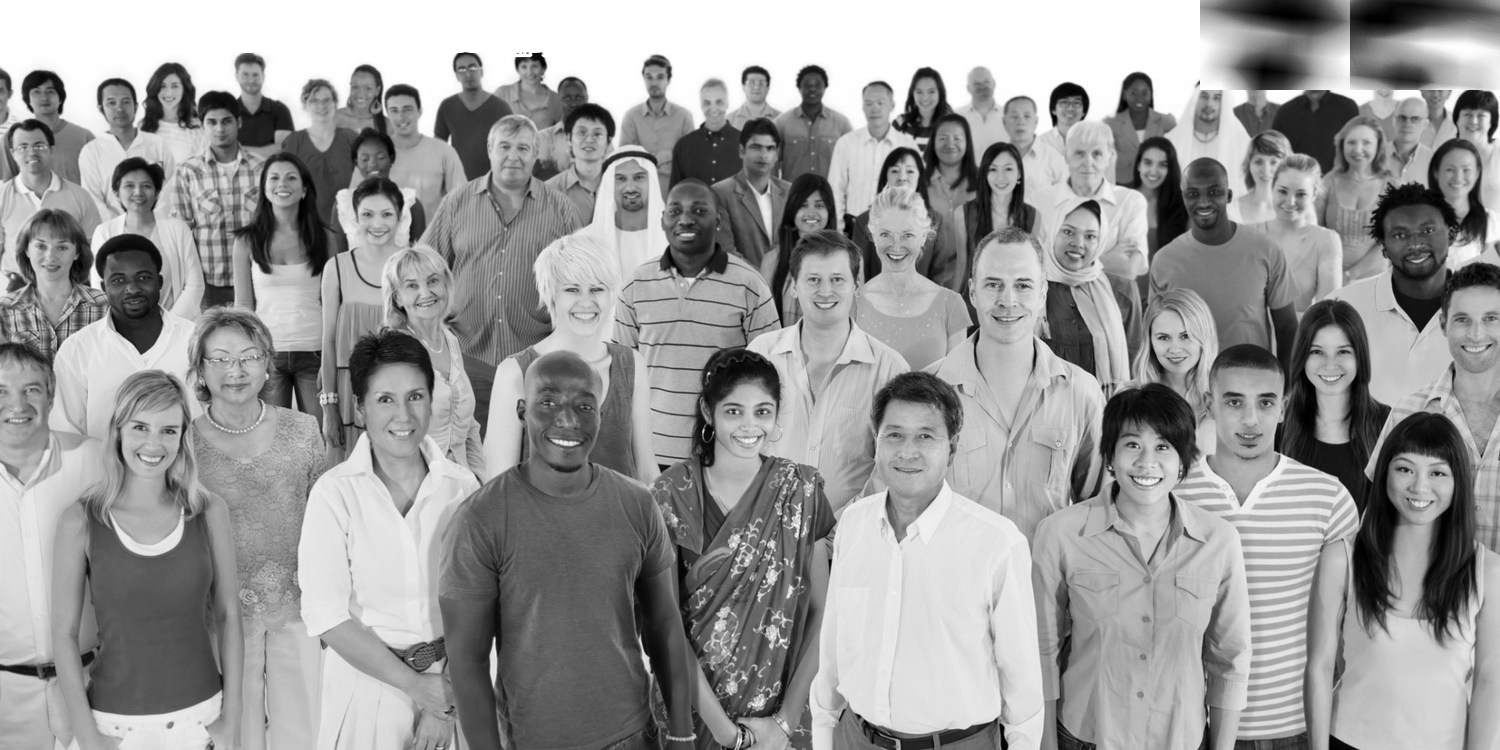

In [6]:
file = 'Diverse_Group_of_People.jpg'
frame = cv2.imread(file) 
gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor('shape_predictor_68_face_landmarks.dat')
rects = detector(gray, 1)

#sample detection
get_eye_landmarks(rects, gray, frame, predictor)
_,frame = get_face_pose(rects, gray, frame, predictor,'tutorial')
cv2.imwrite('detected' + file, frame)
Image.fromarray(frame)

## Dataset creation

In [32]:
def create_learning_dataframe(event):
    #try:
    continious_display = True
    cap = cv2.VideoCapture(0)
    root = tk.Tk()
    screen = root.winfo_screenheight(), root.winfo_screenwidth()
    coord = np.random.choice(screen[1]), np.random.choice(screen[0])
    white = draw_random_point(coord, screen)
    model = 'tutorial'

    # Display the resulting frame
    cv2.namedWindow("test", cv2.WND_PROP_FULLSCREEN)          
    cv2.setWindowProperty("test", cv2.WND_PROP_FULLSCREEN, cv2.WINDOW_FULLSCREEN)

    #init face detector and landmark predictor
    detector = dlib.get_frontal_face_detector()
    predictor = dlib.shape_predictor('shape_predictor_68_face_landmarks.dat')

    participant = pt_name.value
    path = 'Data/' + participant
    df = pd.DataFrame(columns=['Time', 'X', 'Y', 'Eye landmarks', 'Rvect', 'Image', 'Screen size'])

    if not os.path.exists(path):
        os.makedirs(path)

    i = 0
    while(True):
        key = cv2.waitKey(1)

        if key == 27:
            break

        elif key == ord(' '):
            if i%2 == 0:

                #capturing frame
                ret, frame = cap.read()
                ret, frame = cap.read()
                gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

                #faces detection
                rects = detector(gray, 1)

                #sample detection
                sample = {}
                img_name = str(int(i/2)) + '.png'
                sample['Y'], sample['X'] = coord[1]/screen[0], coord[0]/screen[1] 
                sample['Time'] = time()
                sample['Screen size'] = screen
                sample['Image'] = img_name
                if len(rects) > 0:
                    sample['Eye landmarks'] = get_eye_landmarks(rects, gray, frame, predictor)
                    sample['Rvect'] = tuple(get_face_pose(rects, gray, frame, predictor).ravel())
                    _, frame = get_face_pose(rects, gray, frame, predictor, model)

                    
                    if len(sample['Eye landmarks']) > 0:
                        cv2.imwrite(path + '/' + img_name, frame)
                        sample_df = pd.DataFrame.from_dict(sample, orient='index')
                    if not continious_display:
                        df = df.append(sample, ignore_index=True)

                #display(df)
                clear_output(wait=True)

                #drawing random circle
                coord = np.random.choice(screen[1]), np.random.choice(screen[0])
                white = draw_random_point(coord, screen)

            i += 1

        if i%2 == 0:
            cv2.imshow('test', white)
        else:
            cv2.imshow('test', frame)


    # When everything done, release the capture
    
    cap.release()
    df.to_csv(path + '/annotations.txt')
    cv2.destroyAllWindows()

In [33]:
pt_name = Text(description='Input name:', value = 'valik')
start = Button(description='Start', button_style='success')
start.on_click(create_learning_dataframe)
box = HBox([pt_name, start])

In [40]:
display(box)
cv2.destroyAllWindows()

HBox(children=(Text(value='valik', description='Input name:'), Button(button_style='success', description='Start', style=ButtonStyle())))

## Anotation creation

In [2]:
from scipy.io import loadmat
import numpy as np
from PIL import Image
import glob

In [125]:
files = 'MPIIGaze/Data/Original/p01/day01'
images = glob(files + '/*.jpg', recursive=True)
slider = IntSlider(min = 0, max = len(images), layout=Layout(width='700px'))

In [126]:
def draw_sample(x):
    sample_n = x
    image = cv2.imread(images[sample_n]) 
    annot = pd.read_csv(files + '/annotation.txt', delimiter=' ', names= np.arange(41))
    im_landmarks = annot.loc[:,:23].iloc[sample_n].values
    im_landmarks = im_landmarks.reshape((12, 2))
    for mark in im_landmarks:
        cv2.circle(image, tuple(mark), 1, (200, 0, 0), 2)
    display(Image.fromarray(image))
    clear_output(wait=True)

In [127]:
interact(draw_sample, x=slider)

interactive(children=(IntSlider(value=0, description='x', layout=Layout(width='700px'), max=510), Output()), _dom_classes=('widget-interact',))

<function __main__.draw_sample>

In [ ]:
image = cv2.imread(images[sample_n]) 
Image.fromarray(image)

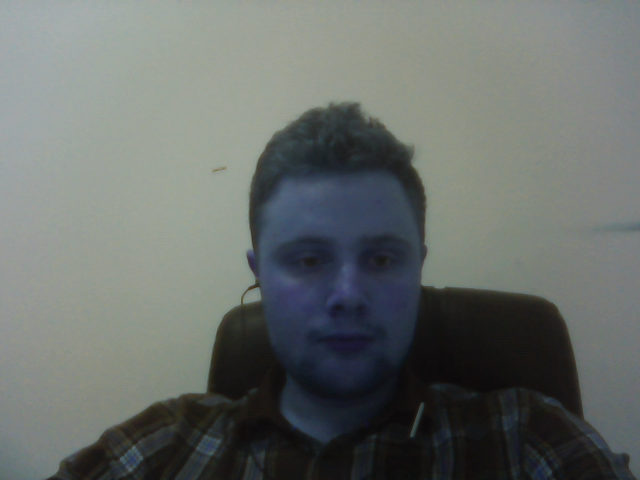

In [70]:
cap = cv2.VideoCapture(0)
ret, frame = cap.read()
cap.release()
cv2.imwrite('example.png', frame)
Image.fromarray(frame)

In [71]:
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor('shape_predictor_68_face_landmarks.dat')

In [72]:
gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
rects = detector(gray, 1)

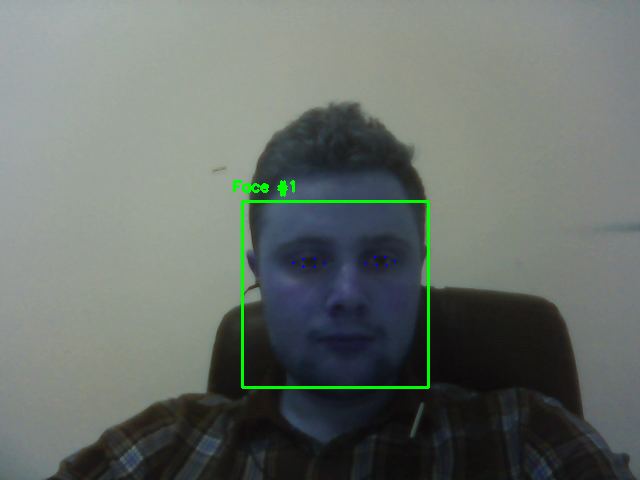

In [73]:
for (i, rect) in enumerate(rects):
    # determine the facial landmarks for the face region, then
    # convert the facial landmark (x, y)-coordinates to a NumPy
    # array
    shape = predictor(gray, rect)
    shape = face_utils.shape_to_np(shape)
    
    # convert dlib's rectangle to a OpenCV-style bounding box
    # [i.e., (x, y, w, h)], then draw the face bounding box
    (x, y, w, h) = face_utils.rect_to_bb(rect)
    cv2.rectangle(frame, (x, y), (x + w, y + h), (0, 255, 0), 2)
    
    # show the face number
    cv2.putText(frame, "Face #{}".format(i + 1), (x - 10, y - 10),
        cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)
    
    # loop over the (x, y)-coordinates for the facial landmarks
    # and draw them on the image
    i = 1
    for (x, y) in shape:
        if i in np.arange(37, 49):
            cv2.circle(frame, (x, y), 1, (0, 0, 255), -1)
        i += 1

Image.fromarray(frame)

In [90]:
cv2.destroyAllWindows()

In [ ]:
def landmarks_for_pose_detection(img):
    detector = dlib.get_frontal_face_detector()
    predictor = dlib.shape_predictor('shape_predictor_68_face_landmarks.dat')
    

In [89]:
 
# Read Image
im = cv2.imread("headPose.jpg");
size = im.shape
     
#2D image points. If you change the image, you need to change vector
image_points = np.array([
                            (359, 391),     # Nose tip
                            (399, 561),     # Chin
                            (337, 297),     # Left eye left corner
                            (513, 301),     # Right eye right corne
                            (345, 465),     # Left Mouth corner
                            (453, 469)      # Right mouth corner
                        ], dtype="double")
 
# 3D model points.
model_points = np.array([
                            (0.0, 0.0, 0.0),             # Nose tip
                            (0.0, -330.0, -65.0),        # Chin
                            (-225.0, 170.0, -135.0),     # Left eye left corner
                            (225.0, 170.0, -135.0),      # Right eye right corne
                            (-150.0, -150.0, -125.0),    # Left Mouth corner
                            (150.0, -150.0, -125.0)      # Right mouth corner
                         
                        ])
# Camera internals

focal_length = size[1]
center = (size[1]/2, size[0]/2)
camera_matrix = np.array(
                         [[focal_length, 0, center[0]],
                         [0, focal_length, center[1]],
                         [0, 0, 1]], dtype = "double"
                         )
 
print ("Camera Matrix :\n {0}".format(camera_matrix))
 
dist_coeffs = np.zeros((4,1)) # Assuming no lens distortion
(success, rotation_vector, translation_vector) = cv2.solvePnP(model_points, image_points, camera_matrix, dist_coeffs, flags=cv2.SOLVEPNP_ITERATIVE)
 
print ("Rotation Vector:\n {0}".format(rotation_vector))
print ("Translation Vector:\n {0}".format(translation_vector))

# Project a 3D point (0, 0, 1000.0) onto the image plane.
# We use this to draw a line sticking out of the nose

(nose_end_point2D, jacobian) = cv2.projectPoints(np.array([(0.0, 0.0, 1000.0)]), rotation_vector, translation_vector, camera_matrix, dist_coeffs)
 
for p in image_points:
    cv2.circle(im, (int(p[0]), int(p[1])), 3, (0,0,255), -1)
 
 
p1 = ( int(image_points[0][0]), int(image_points[0][1]))
p2 = ( int(nose_end_point2D[0][0][0]), int(nose_end_point2D[0][0][1]))
 
cv2.line(im, p1, p2, (255,0,0), 2)
 
# Display image
cv2.imshow("Output", im)
cv2.waitKey(0)

Camera Matrix :
 [[1.200e+03 0.000e+00 6.000e+02]
 [0.000e+00 1.200e+03 3.375e+02]
 [0.000e+00 0.000e+00 1.000e+00]]
Rotation Vector:
 [[-0.05800198]
 [ 2.20224639]
 [ 0.01942058]]
Translation Vector:
 [[  449.51968738]
 [  -94.74161089]
 [-2343.96945188]]


32